In [280]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [281]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import finance_modules as fm

In [282]:
# load the dataset
unzipped_data = 'C:/Users/akiny/OneDrive - University of Rochester/finance_coursera/unzipped_data'
path = f"{unzipped_data}/data/ind30_m_vw_rets.csv"
df = pd.read_csv(path, index_col=0, header=0, parse_dates=True)
df.index = pd.to_datetime(df.index, format="%Y%m").to_period("M")
df.columns = df.columns.str.strip(" ")
df = df["1996":"2000"]/100
df.head()
#df[["Food", "Beer"]]

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1996-01,0.0342,0.0326,0.0182,0.0469,-0.0049,0.0285,-0.0236,0.0595,0.0543,-0.0392,...,0.0233,0.0143,0.0215,0.0121,-0.0012,-0.0065,-0.0146,0.0657,0.0393,0.0283
1996-02,0.0162,0.0561,0.0318,0.0179,0.0233,-0.0044,0.0187,-0.0107,0.0276,0.0024,...,-0.0220,0.0423,0.0677,-0.0104,0.0418,0.0294,0.0553,0.0342,0.0213,0.0151
1996-03,-0.0382,0.0190,-0.0768,0.0108,0.0027,0.0130,0.1149,0.0024,0.0588,0.0268,...,-0.0187,0.0157,-0.0460,0.0306,0.0326,0.0243,0.0825,0.0083,0.0096,0.0500
1996-04,-0.0032,-0.0089,-0.0160,0.0237,0.0285,0.0388,0.0541,-0.0060,-0.0087,0.0346,...,0.0270,0.0820,0.1056,0.0274,0.0265,0.0468,0.0436,0.0271,-0.0108,0.0269
1996-05,0.0550,0.0969,0.0548,0.0279,0.0349,0.0325,0.0805,0.0393,-0.0037,0.0577,...,0.0006,0.0352,0.0418,0.0144,-0.0028,0.0383,0.0511,0.0041,0.0141,0.0432


In [213]:
# calculate return for a pair of assets using the imported module fm
import finance_modules as fm
fm.annualize_ret(df[["Beer", "Food"]], 12)

Beer    0.141126
Food    0.116799
dtype: float64

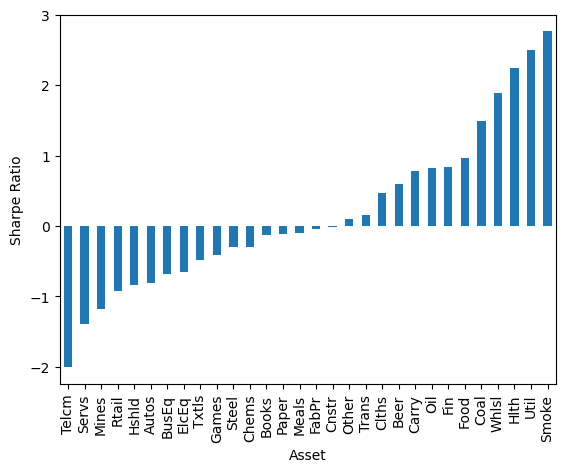

In [284]:
# plot the sharpe ratio of assets assuming 3% risk-free rate and records entered every month 
fm.sharpe_ratio(df["2000":], 0.03, 12).sort_values().plot.bar()
plt.xlabel("Asset"); plt.ylabel("Sharpe Ratio")
plt.show()

In [285]:
# define portfolio return and volatility for a data series of assets
def portfolio_rets(weights, return_series):
    ann_ret = fm.annualize_ret(return_series, 12)
    resultant = weights.T@ann_ret
    return resultant
def portfolio_vola(weights, return_series):
    cov = return_series.cov()
    resultant = weights.T@cov@weights
    return resultant**0.5
    
weights = np.array([0.25, 0.25, 0.25, 0.25])
l = ["Food", "Beer", "Smoke", "Coal"]
data = df[l]
print(f"portfolio volatility: {portfolio_vola(weights,data).round(3)}")
print(f"portfolio return: {portfolio_rets(weights,data).round(3)}")

portfolio volatility: 0.055
portfolio return: 0.195


In [286]:
df.cov().loc[l,l]

,Food,Beer,Smoke,Coal
Food,0.002609,0.002379,0.002061,0.000027
Beer,0.002379,0.005264,0.001359,0.001728
Smoke,0.002061,0.001359,0.008349,-0.000733
Coal,0.000027,0.001728,-0.000733,0.018641


# Efficient frontiers fucntion (2-asset case)

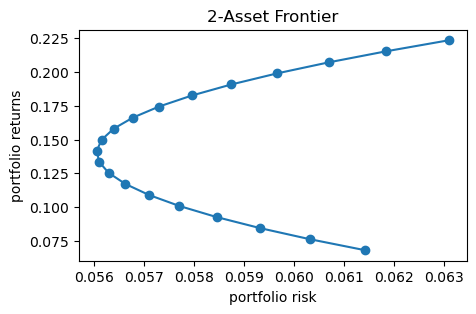

In [288]:
# plot a series of portfolio returns against the corresponding volatilities for different weight allocations between 2 assets

def plot_ef2(return_series, n_points, periods_per_year):
    weights = np.array([[w,1-w] for w in np.linspace(0,1,n_points)])
    #port_returns = portfolio_return(weights, return_series, periods_per_year).reshape(2,1)
    port_returns = [portfolio_rets(weight,return_series) for weight in weights]
    port_vola = [portfolio_vola(weight, return_series) for weight in weights]
    dict_ = {"port_returns":port_returns, "port_vola":port_vola}
    fig = plt.figure(figsize=(5,3))
    plt.plot(port_vola, port_returns)
    plt.scatter(port_vola, port_returns)
    plt.xlabel("portfolio risk"); plt.ylabel("portfolio returns");
    plt.title("2-Asset Frontier")



    
plot_ef2(df[["Games","Fin"]], 20, 12)
    

# N Asset Case

In [289]:
from scipy.optimize import minimize

the optimized portfolio volatility for target return = 0.15 is 0.049


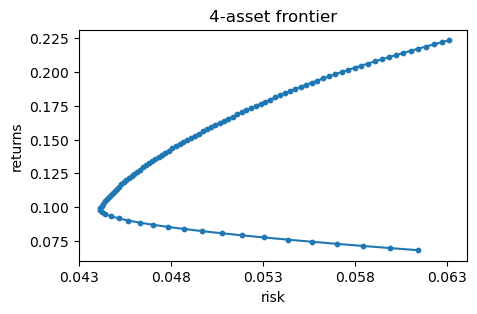

In [290]:
import finance_modules as fm

def minimize_vol(target_return, er,cov):
    n=er.shape[0]
    init_guess=np.repeat(1/n,n)
    bounds = ((0,1),)*n
    weight_constraint = {"type":"eq",
                        "fun": lambda weights: sum(weights)-1}
    target_constraint = {"type": "eq",
                        "fun": lambda weights, er: target_return - portfolio_return(weights, er),
                        "args": (er,),}
    weights = minimize(fm.portfolio_volatility, init_guess,  args=(cov,), method="SLSQP", 
                       options={"disp": False}, constraints=(weight_constraint, target_constraint),
                     bounds=bounds)
    return weights.x
    
# generate the expected_return er, portfolio_return, and covariance cov
def annualize_ret(return_series: pd.Series, periods_per_year):
    num_periods = return_series.shape[0]
    overall_ret = (1+return_series).prod()
    period_ret = (overall_ret)**(1/num_periods)
    annual_ret = (period_ret)**(periods_per_year)-1
    return annual_ret

assets = ["Games", "Fin", "Food", "Beer"]
# define the expected return er
er = annualize_ret(df[assets], 12) 
# define the covariance matrix of the assets
cov = df[assets].cov()

# optimized weights (corresponding to minimized risk for a given level of return)
target_return = 0.15
weights = minimize_vol(target_return, er, cov)
vol15 = fm.portfolio_volatility(weights, cov)
print(f"the optimized portfolio volatility for target return = {target_return} is {vol15.round(3)}")

""" to plot efficient frontier, you iterate over a range of values for target return, We may choose the 
 minimum and maximum expected returns for the assets being considered, since these represent the maximum and minimum 
 possible returns for any possible weight allocation"""

min_ret = er.min() 
max_ret = er.max()

#define 
target_returns = np.linspace(min_ret, max_ret, 100)
minimized_vol = [portfolio_volatility(minimize_vol(i, er, cov), cov) for i in target_returns]

fig = plt.figure(figsize=(5,3))
plt.plot(minimized_vol, target_returns)
plt.scatter(minimized_vol, target_returns, s=10)
plt.xlabel("risk"); plt.ylabel("returns")
plt.xticks(np.arange(0.043,0.065, 0.005))
plt.title(f"{len(assets)}-asset frontier")
#plt.legend()
plt.show()


In [291]:
# define the negative sharpe ratio (we minimize this in order to maximum the sharpe ratio)
def neg_sharpe_ratio(weights, rf, er, cov):
    portfolio_vola = portfolio_volatility(weights, cov)
    sharpe = (weights@er - rf)/portfolio_vola
    return -sharpe

# define a function to minimize the sharpe ratio with the constraint that the weights sum up to 1 and bounded (0,1)
def maximize_sharpe(rf, er, cov):
    n = cov.shape[0]
    init_guess = np.repeat(1/n,n) # initial guess for the weights
    weights_sum_to_1 = {"type":"eq",
                      "fun": lambda weights: sum(weights)-1}
    bounds = ((0,1),)*n  # each weight is bounded between 0 and 1, inclusively.
    weights = minimize(neg_sharpe_ratio, init_guess, bounds=bounds, constraints=(weights_sum_to_1),
                       method="SLSQP", args=(rf, er, cov), options={"disp":False})
    return weights.x

rf = 0.03
assets = ["Games", "Fin", "Food", "Games"]
er = annualize_ret(df[assets], 12)
cov = df[assets].cov()
weights = maximize_sharpe(rf, er, cov) 
weight_dict = {i:j for i,j in zip(assets, weights)}
print(f"optimized weights = {weight_dict}")
max_sharpe_ratio_weight = weights@er
max_sharpe_ratio_vola = portfolio_volatility(weights, cov)
print(f"maximum sharpe ratio = {(max_sharpe_ratio_weight/max_sharpe_ratio_vola).round(2)}")

optimized weights = {'Games': 6.106226635438361e-16, 'Fin': 0.9999999999999998, 'Food': 0.0}
maximum sharpe ratio = 3.54


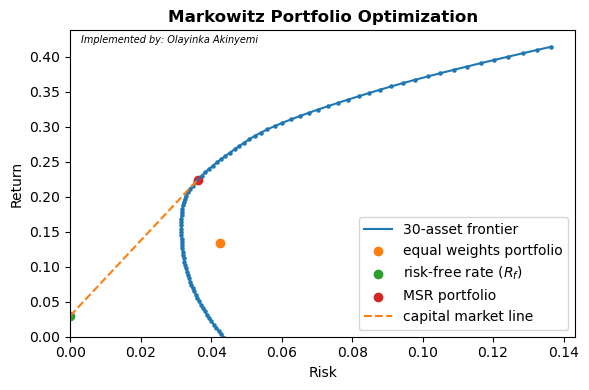

In [314]:
def plot_ef(er, cov, rf, equal_weights=False, cml=False):
    n = er.shape[0]
    er_min = min(er)
    er_max = max(er)
    range_ = np.linspace(er_min, er_max, 100)
    portfolio_ret = [minimize_vol(i, er, cov)@er for i in range_]
    portfolio_vola = [portfolio_volatility(minimize_vol(i, er, cov), cov) for i in range_]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(portfolio_vola, portfolio_ret, s=5)
    ax.plot(portfolio_vola, portfolio_ret,  label=f"{n}-asset frontier")
    ax.set_xlabel("Risk"); ax.set_ylabel("Return")
    
    if equal_weights:
        weights = np.repeat(1/n,n)
        portfolio_ret = weights@er
        portfolio_vola = portfolio_volatility(weights, cov)
        ax.scatter(portfolio_vola, portfolio_ret, label="equal weights portfolio")
    
    if cml:
        weights = maximize_sharpe(rf, er, cov)
        max_sharpe_ratio_return = weights@er
        max_sharpe_ratio_vola = portfolio_volatility(weights, cov)
        cml_x = [0, max_sharpe_ratio_vola]
        cml_y = [rf, max_sharpe_ratio_return]
        ax.scatter(cml_x[0], cml_y[0], label="risk-free rate ($R_f$)")
        ax.scatter(cml_x[1], cml_y[1], label="MSR portfolio")
        ax.plot(cml_x, cml_y, "--", label =  "capital market line")
    
    ax.set_xlim(0); ax.set_ylim(0)
    ax.text(0.003,0.42,"Implemented by: Olayinka Akinyemi", fontstyle="italic", fontsize=7)
    ax.set_title("Markowitz Portfolio Optimization", fontweight="bold")
    ax.legend()
    fig.tight_layout()
    plt.savefig("markowitz-optimization.png")
    plt.show()
    
    
#assets = ["Games", "Fin", "Food", "Beer"]
assets = df.columns
cov = df[assets].cov()
er = annualize_ret(df[assets], 12)
rf = 0.03
plot_ef(er, cov, rf, equal_weights=True, cml=True)
